In [1]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

pd.set_option('display.max_columns', None)


In [2]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [3]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [4]:
data['Spring'] = data['ApprovalMonth'].isin([3, 4, 5]).astype(int)
data['Summer'] = data['ApprovalMonth'].isin([6, 7, 8]).astype(int)
data['Autumn'] = data['ApprovalMonth'].isin([9, 10, 11]).astype(int)
data['Winter'] = data['ApprovalMonth'].isin([12, 1, 2]).astype(int)


# Calculate the count of urban and rural businesses in each state
urban_rural_counts = data.groupby(['State', 'UrbanRural']).size().unstack(fill_value=0)

# Calculate the ratio of urban to rural businesses in each state
urban_rural_counts['UrbanRuralBusinessRatio'] = urban_rural_counts[1] / (urban_rural_counts[0] + urban_rural_counts[1])
urban_rural_counts = urban_rural_counts['UrbanRuralBusinessRatio']

# Merge this ratio back into the original dataframe
data = data.merge(urban_rural_counts, on='State', how='left')

# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [5]:
state_to_coords = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Apply the mapping to the dataset to create new latitude and longitude columns
data['Latitude'] = data['State'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['Longitude'] = data['State'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)
data['BankState_Latitude'] = data['BankState'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['BankState_Longitude'] = data['BankState'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)

# Calculate the distance between State and BankState
data['State_BankState_Distance'] = data.apply(lambda x: haversine(x['Latitude'], x['Longitude'], 
                                                                   x['BankState_Latitude'], x['BankState_Longitude']) 
                                              if pd.notnull(x['Latitude']) and pd.notnull(x['BankState_Latitude']) 
                                              else None, axis=1)

In [6]:
data.isna().sum()

ID                                      0
Term                                    0
NoEmp                                   0
NewExist                                0
CreateJob                               0
RetainedJob                             0
FranchiseCode                           0
RevLineCr                            2120
LowDoc                               1051
MIS_Status                          42308
Sector                                  0
ApprovalFY                              0
City                                    0
State                                   0
BankState                              27
DisbursementGross                       0
GrAppv                                  0
SBA_Appv                                0
UrbanRural                              0
train                                   0
NewBusiness                             0
DisbursementYear                      310
DisbursementMonth                     310
DisbursementDay                   

In [12]:
data['BankState'][data['BankState_Latitude'].isnull()].unique()

['DC', NaN, 'PR']
Categories (52, object): ['AK', 'AL', 'AR', 'AZ', ..., 'WA', 'WI', 'WV', 'WY']

In [83]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [13]:
# train['CityCount'] = train.groupby('City')['City'].transform('count')
# train['BankStateCount'] = train.groupby('BankState')['BankState'].transform('count')
# train['StateCount'] = train.groupby('State')['State'].transform('count')
# train['SectorCount'] = train.groupby('Sector')['Sector'].transform('count')

# test['CityCount'] = test.groupby('City')['City'].transform('count')
# test['BankStateCount'] = test.groupby('BankState')['BankState'].transform('count')
# test['StateCount'] = test.groupby('State')['State'].transform('count')
# test['SectorCount'] = test.groupby('Sector')['Sector'].transform('count')


NameError: name 'train' is not defined

In [86]:
# lgb_train = pd.read_csv('../data/train_lgb_predictions3.csv')
# lgb_test = pd.read_csv('../data/test_lgb_predictions3.csv')

# # cb_train = pd.read_csv('../data/train_cb_predictions.csv')
# # cb_test = pd.read_csv('../data/test_cb_predictions.csv')

# # # rf_train = pd.read_csv('../data/Stacking/rf/train_rf_predictions.csv')
# # # rf_test = pd.read_csv('../data/Stacking/rf/test_rf_predictions.csv')

# from functools import reduce

# train = reduce(lambda left, right: pd.merge(left, right, on='ID'), [train, lgb_train])

# test = reduce(lambda left, right: pd.merge(left, right, on='ID'), [test, lgb_test])

In [87]:
train

,ID,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,NewBusiness,DisbursementYear,DisbursementMonth,DisbursementDay,ApprovalMonth,ApprovalDay,IsSameState,LoanProcessingPeriod,LoanvsApprovedAmountDifference,SBAGuaranteeRatio,YearsSinceApproval,FranchiseFlag,Jobs_Created_per_Employee,Jobs_Retained_per_Employee,Loan_Amount_per_Employee,LoanToValueRatio,RealEstate,GreatRecession,AppvDisbursed,RatioOfJobsCreatedToJobsRetained,Spring,Summer,Autumn,Winter,UrbanRuralBusinessRatio,missing_values_count,Latitude,Longitude,BankState_Latitude,BankState_Longitude,State_BankState_Distance,CityCount,BankStateCount,StateCount,SectorCount
0,0,163,21,1.0,0,0,1,N,N,1,Other,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,0.0,1998.0,1.0,31.0,9,22,False,-3156.0,0.0,0.85,18,NaN,0.000000,0.000000,3809.523810,1.0000,0,1,1,NaN,0,0,1,0,0.210920,2,33.729759,-111.431221,44.299782,-99.438828,1563.425413,324,2382.0,768,9798
1,1,84,6,1.0,4,0,0,0,N,1,Healthcare/Social_assist,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,0.0,1993.0,10.0,31.0,6,30,True,488.0,0.0,0.80,32,NaN,0.666667,0.000000,47833.333333,1.0000,0,0,1,NaN,0,1,0,0,0.296460,2,35.565342,-96.928917,35.565342,-96.928917,0.000000,8,453.0,527,1191
2,2,242,45,1.0,4,90,0,N,N,1,Wholesale_trade,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,0.0,2001.0,8.0,31.0,4,18,True,135.0,-1983.0,0.50,23,NaN,0.088889,2.000000,710.733333,1.0661,1,1,0,0.044444,1,0,0,0,0.299387,1,40.298904,-74.521011,40.298904,-74.521011,0.000000,6,195.0,488,7337
3,3,237,4,1.0,0,0,0,N,N,1,Manufacturing,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,0.0,2007.0,8.0,31.0,10,6,False,1425.0,0.0,1.00,20,NaN,0.000000,0.000000,57250.000000,1.0000,0,1,1,NaN,0,0,1,0,0.302513,2,35.747845,-86.692345,44.299782,-99.438828,1439.951815,599,2382.0,1147,6053
4,4,184,0,1.0,0,0,0,N,N,1,Other,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,0.0,1983.0,6.0,8.0,12,17,True,-6036.0,0.0,0.75,24,NaN,NaN,NaN,NaN,1.0000,0,0,1,NaN,0,0,0,1,0.319871,5,36.116203,-119.681564,36.116203,-119.681564,0.000000,584,6476.0,6893,9798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,42302,283,14,1.0,0,0,1,N,N,1,Other,1995,PHILADELPHIA,PA,PA,80000.0,80000.0,68000.0,0,0.0,1998.0,1.0,31.0,3,2,True,1066.0,0.0,0.85,29,NaN,0.000000,0.000000,5714.285714,1.0000,1,1,1,NaN,1,0,0,0,0.259134,2,40.590752,-77.209755,40.590752,-77.209755,0.000000,612,1307.0,2849,9798
42303,42303,53,2,1.0,0,0,0,Y,N,1,Wholesale_trade,2007,LOS ANGELES,CA,SD,5000.0,5000.0,4250.0,1,0.0,1991.0,4.0,3.0,6,6,False,-5908.0,0.0,0.85,17,NaN,0.000000,0.000000,2500.000000,1.0000,0,0,1,NaN,0,1,0,0,0.319871,2,36.116203,-119.681564,44.299782,-99.438828,1937.621245,348,2382.0,6893,7337
42304,42304,59,6,2.0,0,0,1,N,N,1,Wholesale_trade,2003,COLUMBUS,OH,OH,60000.0,60000.0,51000.0,0,1.0,2003.0,2.0,28.0,3,14,True,-14.0,0.0,0.85,21,NaN,0.000000,0.000000,10000.000000,1.0000,0,1,1,NaN,1,0,0,0,0.344665,2,40.388783,-82.764915,40.388783,-82.764915,0.000000,124,2785.0,1229,7337
42305,42305,295,18,1.0,0,8,0,N,N,1,Wholesale_trade,1989,CLOQUET,MN,MN,294000.0,294000.0,220500.0,0,0.0,1997.0,12.0,10.0,8,23,True,3031.0,0.0,0.75,35,NaN,0.000000,0.444444,16333.333333,1.0000,1,1,1,0.000000,0,1,0,0,0.460023,1,45.694454,-93.900192,45.694454,-93.900192,0.000000,2,824.0,1004,7337


In [88]:
X = train[['Term']]
# スケーラーの初期化と適用
scaler = StandardScaler()
X = scaler.fit_transform(X)
# クラスタ数の候補を設定
n_components = np.arange(1, 10)

# BICを格納するためのリスト
bics = []

# 各クラスタ数に対してGMMをフィットし、BICを計算
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X)
    bics.append(gmm.bic(X))

X = pd.DataFrame(X,columns=["Term"])

# クラスタ数を9に設定し、GMMをフィット
gmm = GaussianMixture(n_components=9, random_state=0)
gmm.fit(X)

# 各データポイントのクラスタ割り当てを取得
cluster_assignments = gmm.predict(X)

# クラスタ割り当て結果をデータフレームに追加
X_clustered = X.copy()
train['Term_Cluster'] = cluster_assignments

# 'Term' 列の選択
X_test = test[['Term']]

# 訓練データでフィットさせたGMMを使用してクラスタ割り当てを予測
test['Term_Cluster'] = gmm.predict(X_test)

In [89]:
train.dtypes

ID                                     int64
Term                                   int64
NoEmp                                  int64
NewExist                             float64
CreateJob                              int64
RetainedJob                            int64
FranchiseCode                          int64
RevLineCr                           category
LowDoc                              category
MIS_Status                          category
Sector                              category
ApprovalFY                             int64
City                                category
State                               category
BankState                           category
DisbursementGross                    float64
GrAppv                               float64
SBA_Appv                             float64
UrbanRural                             int64
NewBusiness                          float64
DisbursementYear                     float64
DisbursementMonth                    float64
Disburseme

In [90]:
category_features = [
    'State',
    'BankState', 
    'Sector',  
    'NewExist',
    'UrbanRural',
    'RevLineCr', 
    'LowDoc',
    'FranchiseFlag',
    'IsSameState',
    'Term_Cluster',
    'Spring',
    'Summer',
    'Autumn',
    'Winter',
    'BankStateCount',
    'CityCount',
    'SectorCount',
    'StateCount',
    'RealEstate',
    'GreatRecession',
    'AppvDisbursed',
    ]

for col in category_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

In [91]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [92]:
from sklearn.model_selection import KFold

# クロスバリデーションの設定
n_splits = 5
kf = KFold(n_splits=n_splits)

# OOF予測用の空配列
oof_preds = np.zeros(train.shape[0])

# テストデータ予測用の空配列
test_preds = np.zeros(test.shape[0])

# クロスバリデーション
for train_index, val_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]

    # 目的変数の設定
    y_train, y_val = X_train['MIS_Status'], X_val['MIS_Status']

    X_train = X_train.drop(['MIS_Status'], axis=1)
    X_val = X_val.drop(['MIS_Status'], axis=1)

    # モデルの訓練
    model = cb.CatBoostClassifier(depth=3,verbose=False, early_stopping_rounds=100)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],cat_features=category_features)

    # OOF予測
    oof_preds[val_index] = model.predict_proba(X_val)[:, 1]

    # テストデータに対する予測
    test_preds += model.predict_proba(test)[:, 1] / n_splits

# 訓練データにOOF予測を追加
train['catboost_preds'] = oof_preds

# テストデータに予測を追加
test['catboost_preds'] = test_preds

In [93]:
# 訓練データとテストデータのCSVファイルに保存する列の選択
train_csv = train[['ID', 'catboost_preds']]
test_csv = test[['ID', 'catboost_preds']]

# CSVファイルに保存
train_csv_path = '../data/train_cb_predictions.csv'
test_csv_path = '../data/test_cb_predictions.csv'

train_csv.to_csv(train_csv_path, index=False)
test_csv.to_csv(test_csv_path, index=False)

train = train.drop(['ID', 'catboost_preds'],axis=1)
test = test.drop(['ID', 'catboost_preds'],axis=1)

In [94]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [95]:
# CatBoostデータセットの作成
train_pool = cb.Pool(X_train, y_train,cat_features=category_features)
test_pool = cb.Pool(X_val, y_val,cat_features=category_features)

In [96]:
models = []
for seed in range(10):
    print('-'*20,seed,'-'*20)
    # データサンプリング
    train_sample = X_train.sample(frac=0.8, random_state=seed)
    y_sample = y_train[train_sample.index]

    # モデルの学習
    cat_clf = cb.CatBoostClassifier(depth=3,verbose=False, early_stopping_rounds=100)  # 進行状況を表示しない場合はverbose=0
    cat_clf.fit(train_sample, y_sample,cat_features=category_features)

    # 検証データに対する予測
    y_pred = cat_clf.predict(X_val)
    y_pred_proba = cat_clf.predict_proba(X_val)[:, 1]  # AUCの計算に使用

    # モデルをリストに追加
    models.append(cat_clf)

In [97]:
# 3. すべてのモデルを使用してトレーニングセットとテストセットの予測を行う。
y_preds_train = []
y_preds_test = []
for model in models:
    y_preds_train.append(model.predict_proba(X_train)[:, 1])
    y_preds_test.append(model.predict_proba(X_val)[:, 1])

In [98]:
# 4. 予測結果を平均して、最終的な予測を得る。
y_pred_train = np.mean(y_preds_train, axis=0)
y_pred = np.mean(y_preds_test, axis=0)

In [117]:
th = 0.8
print(roc_auc_score(y_val, y_pred))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (y_pred >= th)  # True positives
FP = (y_val == 0) & (y_pred >= th)  # False positives
TN = (y_val == 0) & (y_pred < th)  # True negatives
FN = (y_val == 1) & (y_pred < th)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(y_pred > th, 1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else y_pred), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

0.7708481513314804
Total cases: 8462
True positives: 7076 ( 83.62 %)
False positives: 523 ( 6.18 %)
True negatives: 364 ( 4.30 %)
False negatives: 499 ( 5.90 %)
accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.879, 0.931, 0.934, 0.933, 0.771


#accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#0.905, 0.915, 0.985, 0.949, 0.773

In [100]:
# 各モデルからの予測確率を集める
y_preds_proba = [model.predict_proba(test) for model in models]

# 予測確率の平均を計算する
y_proba_avg = np.mean(y_preds_proba, axis=0)

# 最も高い確率のクラスを選択する
y_new_pred = np.argmax(y_proba_avg, axis=1)

In [110]:
# 閾値を設定（例：0.5）
threshold = 0.84

# 閾値を超える確率を持つ予測を1とし、それ以外を0とする
y_pred_threshold = (y_proba_avg[:, 1] >= threshold).astype(int)

# 0と1の割合を計算
zeros = np.sum(y_pred_threshold == 0) / len(y_pred_threshold)
ones = np.sum(y_pred_threshold == 1) / len(y_pred_threshold)

# 結果を表示
print(f"0の割合: {zeros * 100:.2f}%")
print(f"1の割合: {ones * 100:.2f}%")

0の割合: 9.99%
1の割合: 90.01%


In [111]:
submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = y_pred_threshold
filename = 'CB_base'

submit.to_csv('outputs/' + filename + '.csv', index=False,header=None)

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_28880\1853291327.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  submit.iloc[:, 1] = y_pred_threshold


In [112]:
# 特徴量の重要度を取得
importance = cat_clf.feature_importances_

# 特徴量の名前を取得
feature_names = X_train.columns

# 特徴量の重要度を降順にソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度を降順に表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[indices[f]], importance[indices[f]]))

 1) UrbanRural                     13.064390
 2) RevLineCr                      11.721014
 3) LowDoc                         11.636598
 4) NoEmp                          9.802233
 5) CityCount                      8.500087
 6) Term                           3.539156
 7) ApprovalDay                    2.922745
 8) SBA_Appv                       2.569646
 9) Term_Cluster                   2.566243
10) BankStateCount                 1.815046
11) FranchiseCode                  1.675082
12) DisbursementYear               1.518318
13) missing_values_count           1.486919
14) CreateJob                      1.332888
15) GrAppv                         1.307722
16) LoanProcessingPeriod           1.263570
17) Jobs_Retained_per_Employee     1.258969
18) Sector                         1.244692
19) UrbanRuralBusinessRatio        1.212064
20) SBAGuaranteeRatio              1.109710
21) AppvDisbursed                  1.083102
22) RatioOfJobsCreatedToJobsRetained 1.074547
23) Loan_Amount_per_Employe

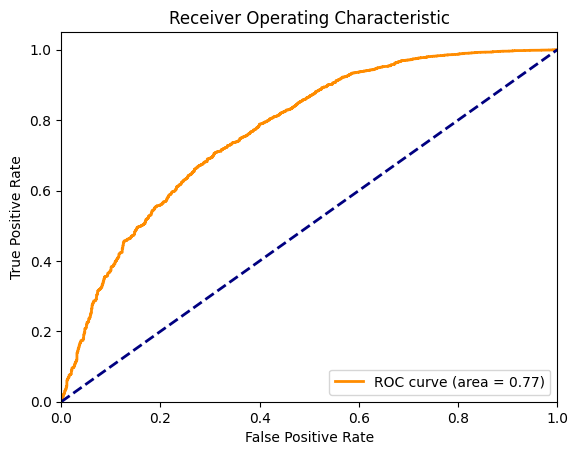

In [113]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

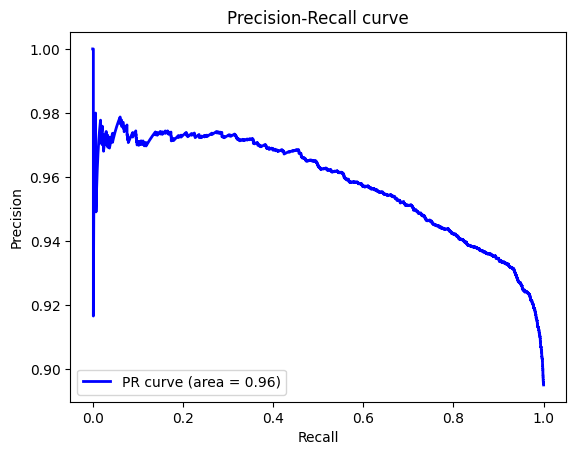

In [114]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()